<a href="https://colab.research.google.com/github/RiverGumSecurity/AILabs/blob/main/examples/PandasExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning with Phishing Email Data

This notebook explores core concepts and and provides examples of supervised machine learning.  We will use phishing emails as a dataset and compare statistcal learning methods, such as Logistic Regression and Support Vector Machines.

In [22]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import datetime
import os 
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import warnings

In [2]:
# Detect GPU device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9131915594799509157
xla_global_id: -1
]


In [3]:
# Set random seed in notebook for consistent results
np.random.seed(42)

## Dataset

The dataset that will be used to train and test the different models was from https://www.kaggle.com/datasets/subhajournal/phishingemails.  It was pre-labeled as "Safe Email" or "Phishing Email".  The data will be cleaned and prepared for training machine learning models with Pandas.


In [4]:
# Read in the data into a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/RiverGumSecurity/AILabs/main/datasets/Phishing_Email.csv')
df.head(10)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


In [5]:
# Print information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [6]:
# Find null values in the data - these can cause issues for computation later in the notebook
df.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [7]:
# Drop null values in place, drop Unamed:0 column, drop duplicates
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [8]:
# Show the shape of the data
df.shape

(17538, 2)

In [9]:
# Display cleaned dataframe
df.head(10)

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,re : coastal deal - with exxon participation u...,Safe Email


In [10]:
# Display the count of Email types, a Safe Email or a Phishing Email
df['Email Type'].value_counts()

Email Type
Safe Email        10980
Phishing Email     6558
Name: count, dtype: int64

<Axes: xlabel='Email Type'>

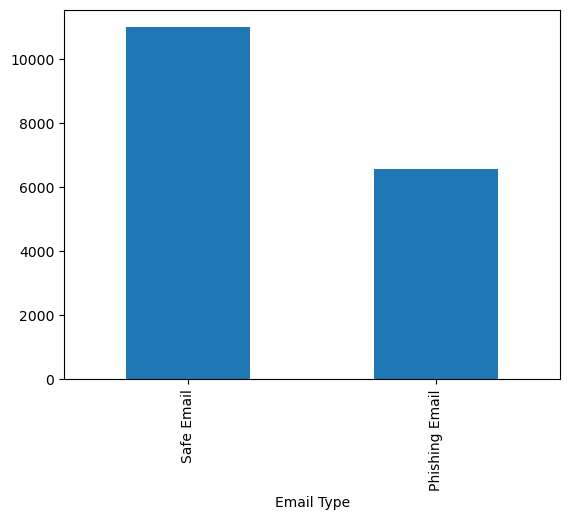

In [11]:
# Plot counts of Safe Email vs Phishing Email
df['Email Type'].value_counts().plot(kind='bar')

Now we need to further process and clean the data. This is a binary classification problem, and we need to assign a label (a 1 or a 0) to the email categories. Then we will remove URLS and non word characters from the emails - we are interested in the similarities of the text itself.  Then we lowercase all of the characters, convert all multiple whitespace characters to single whitespace, and remove any trailing whitespaces.

In [12]:
# Label Email Type
lbl = LabelEncoder()
df['Email Type'] = lbl.fit_transform(df['Email Type'])

In [13]:
# Function to preprocess text.
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['Email Text']=df['Email Text'].apply(preprocess_text)

In [14]:
df.head(10)

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0
5,global risk management operations sally congra...,1
6,on sun aug 11 2002 at 111747am 0100 wintermute...,1
7,entourage stockmogul newsletter ralph velez ge...,0
8,we owe you lots of money dear applicant after ...,0
9,re coastal deal with exxon participation under...,1


Now we convert the text into a TF-IDF (Term Frequencey Inverse Document Frequency) matrix. This a statistical measure that evaluates how relevant a word is to a document in a collection of documents. It combines two metrics: the number of times a word appears in a document (term frequency) and the inverse document frequency of the word across the entire set of documents where each email is a document.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

The Email Type columns is then converted into a numpy array.  Data from both calculations is stored in a class object.

In [17]:
# Convert email text to an array of vectors, removing stop words
tf = TfidfVectorizer(stop_words='english',max_features=10000) #dimension reduction
feature_x = tf.fit_transform(df['Email Text']).toarray()

# convert the label into numpy array
y_tf = np.array(df['Email Type']) 

In [18]:
print(type(tf))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In data science and traning and testing machine learning models, it is common practice to split the data into traning and validation splits.  Usually this is an 80/20 split where 80% of the data is used for training the model, and 20% is used for validation. The validation process is used to measure the accuracy of the model using various statistical measurements.

In [19]:
#split dataset into training and testing data groups, 80 percent training, 20 percent testing
X_tr,X_tst,y_tr,y_tst = train_test_split(feature_x,y_tf,test_size=0.2,random_state=0)

## Logistic Regression

Now that we have split our data into traning and validation sets, we are ready for our first machine learning model that will be able to tell if an email is phishing or not based on the text of the email.  The first model we will explore is Logistic Regression.

Logistic regression is a statistical method used for binary classification, where the goal is to predict the probability that a given input belongs to one of two categories. It models the relationship between a dependent binary variable and one or more independent variables using the logistic function, producing an output between 0 and 1. This output can then be thresholded to classify the input into one of the two categories.

A good explanation of how this works can be found from the good folks at StatQuest:

https://www.youtube.com/watch?v=yIYKR4sgzI8

We will use the SciKit Learn implmentation of the Logistic Regression algorithm:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


## Run Logistic Regression Model

In [25]:
# instantiate Logistic Regression class and fit the model to the data
lg = LogisticRegression()
lg.fit(X_tr,y_tr)

# predict whether class 0 (phishing) or class 1 (not phishing)
pred_lg = lg.predict(X_tst)

## Interpret Logistic Regression Model 

A common way to score and interpret the results of a training and testing run of a machine learning model is with a classification report comparing the predictect results with the validation set (that was not used for training).

In [32]:
# Caclulate the accuracy and the f1 score of the Logistic Regression model.
# store in variables for later
lr_accu = accuracy_score(y_tst,pred_lg)*100
lr_f1 = f1_score(y_tst,pred_lg)*100

#these two lines can probably be deleted
#print("The Logistic Regression model accuracy score was " + str(lr_accu) + "\n")
#print("The Logistic Regression model F1 score was " + str(lr_f1) + "\n")

print(classification_report(y_tst,pred_lg))



              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1351
           1       0.98      0.99      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



So how do we read and interpret this table?

**Precision:** The ratio of correctly predicted positive observations to the total predicted positives. It answers the question: "Of all the instances that the classifier labeled as positive, how many are actually positive?"

**Recall (Sensitivity):** The ratio of correctly predicted positive observations to all observations in the actual class. It answers the question: "Of all the actual positive instances, how many were correctly predicted?"

**F1-Score:** The harmonic mean of precision and recall. It is a better measure than accuracy for imbalanced datasets.

**Support:** The number of actual occurrences of the class in the dataset.

**Accuracy:** The ratio of correctly predicted instances to the total instances. For this model, the accuracy is 0.98 (98%), meaning 98% of the predictions are correct.

**Macro Average:** The average of precision, recall, and F1-score calculated for each class independently and then averaged. This metric treats all classes equally.

**Weighted Average:** The average of precision, recall, and F1-score, weighted by the number of instances in each class (support). This metric is more representative when there is a class imbalance.

Another way tp evaluate a classification model is a confusion matrix.  This is a table showing the counts of true positive, true negative, false positive, and false negative predictions. Each row of the matrix represents the actual class, while each column represents the predicted class, allowing for a clear visualization of where the model is making correct and incorrect predictions. This helps in understanding the model's accuracy, precision, recall, and other performance metrics.

**Confusion Matrix for the Logistic Regression Model**

- upper left - number of emails predicted to be phishing and are actually phishing (True Positive)

- upper right - number of emails predicted as not phishing that are actually phishing (False Positive)

- lower left - number emails predicted to be phishing that are actually not phishing (False Negative)

- lower right - number of emails predicted ast not phishing that are actually not phishing (True Negative)

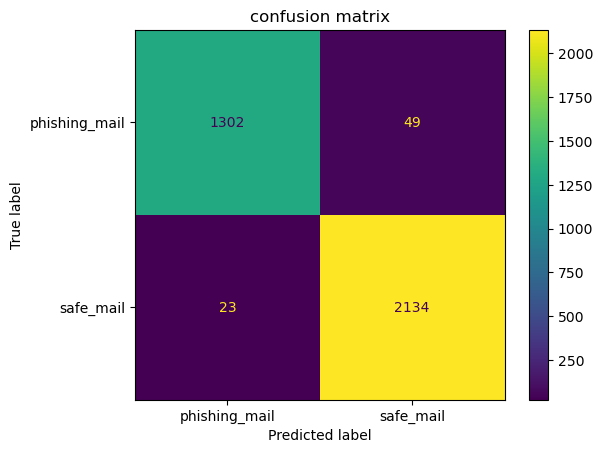

In [33]:
clf_lg = confusion_matrix(y_tst,pred_lg)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

### Support Vector Machine
https://scikit-learn.org/stable/modules/svm.html#classification

In [19]:
svm = LinearSVC()
svm.fit(X_tr,y_tr)

pred_svm = svm.predict(X_tst)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


The SVM model accuracy score was 98.46066134549602

The SVM model F1 score was 98.7505784359093

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.99      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



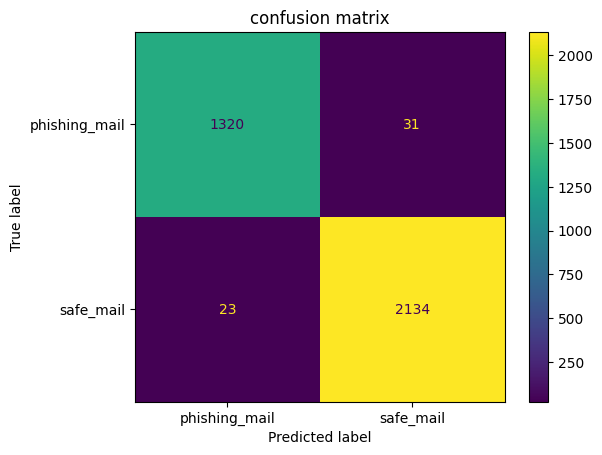

In [20]:
svm_accu = accuracy_score(y_tst,pred_svm)*100
svm_f1 = f1_score(y_tst,pred_svm)*100


print("The SVM model accuracy score was " + str(svm_accu) + "\n")
print("The SVM model F1 score was " + str(svm_f1) + "\n")

print(classification_report(y_tst,pred_svm))

clf_lg = confusion_matrix(y_tst,pred_svm)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## Multinomial Naive Bayes 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#:~:text=The%20multinomial%20Naive%20Bayes%20classifier,tf%2Didf%20may%20also%20work.

In [34]:
nb = MultinomialNB()
nb.fit(X_tr,y_tr)

MultinomialNB()

In [22]:

pred_nav = nb.predict(X_tst)
nb_accu = accuracy_score(y_tst,pred_nav)*100
nb_f1 = f1_score(y_tst,pred_nav)*100

print("The Naive Bayes model accuracy score was " + str(nb_accu) + "\n")
print("The Maive Bayes model F1 score was " + str(nb_f1) + "\n")

print(classification_report(y_tst,pred_nav))



The Naive Bayes model accuracy score was 97.51995438996579

The Maive Bayes model F1 score was 97.98936907788305

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.98      0.98      0.98      3508



Confusion Matrix
upper left - number of emails predicted to be phishing and are actually phishing (True Positive)
upper right - number of emails predicted as not phishing that are actually phishing (False Positive)
lower left - number emails predicted to be phishing that are actually not phishing (False Negative)
lower right - number of emails predicted ast not phishing that are actually not phishing (True Negative)

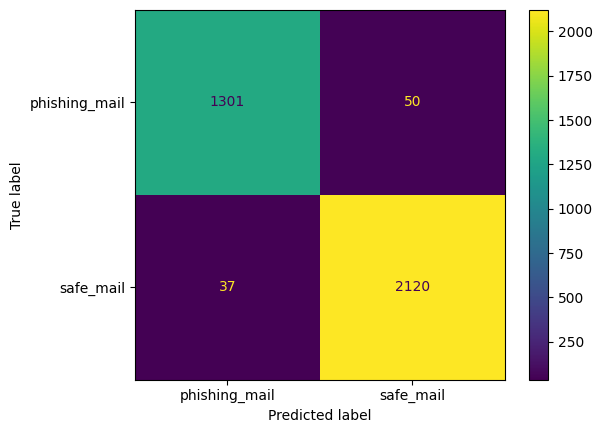

In [23]:
clf_nav = confusion_matrix(y_tst,pred_nav)
cx_ = ConfusionMatrixDisplay(clf_nav,display_labels=['phishing_mail','safe_mail']).plot()
plt.show()

Text(0, 0.5, 'Loss')

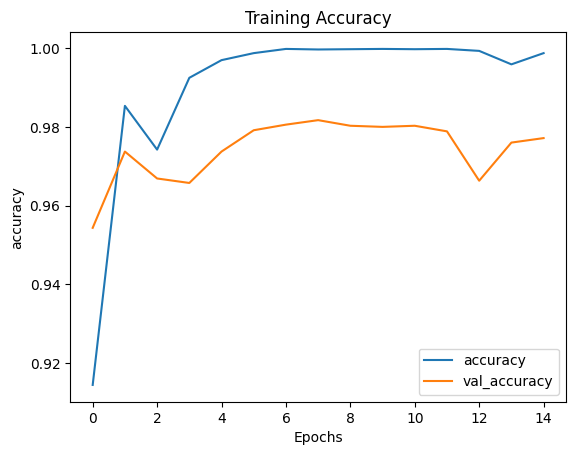

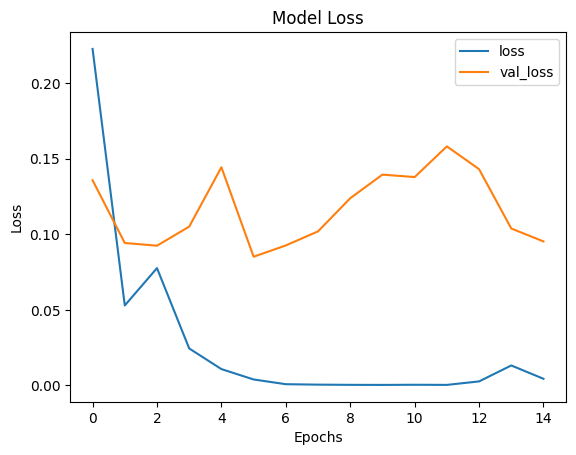

In [48]:
pd.DataFrame(historical_bi.history)

pd.DataFrame(historical_bi.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_bi.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

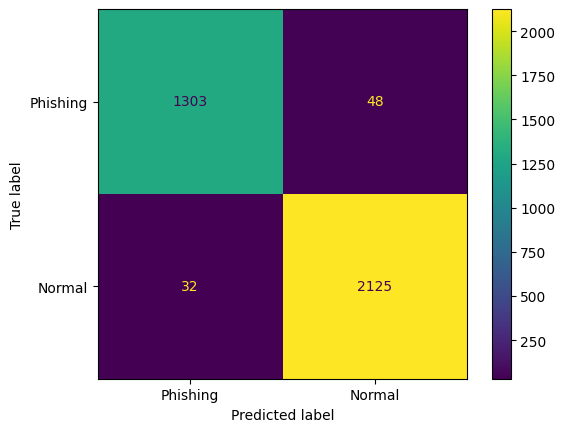

In [49]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Phishing','Normal'])
ax_bi.plot()
plt.show()

# Comparisons



In [56]:
# Need to do - set up table of models and comparisons

accu_values = [lr_accu,svm_accu,nb_accu]
row_labels = ["Logistic Regression", "SVM", "Naive Bayes"]
comp_df = pd.DataFrame(accu_values, columns=["accuracy"], index=row_labels)
print(comp_df)

                               accuracy
Logistic Regression           97.947548
SVM                           98.460661
Naive Bayes                   97.519954
Simple RNN                    71.180159
LSTM Neural Network           97.633982
Bidirectional Neural Network  97.719496
Gated Reccurent Unit          98.004562
